In [1]:
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional, Conv1D
from tensorflow.keras.optimizers import RMSprop, Adam
import spacy
from spacy_langdetect import LanguageDetector
import numpy as np
import random
import sys
import io
import requests
import re
import pandas
from tensorflow.keras import layers 
from tensorflow.keras import callbacks 
from langdetect import detect_langs
import tensorflow as tf
import matplotlib.pyplot as plt  # import matplotlib for plotting and visualization
import matplotlib
from sklearn.metrics import classification_report


In [2]:
t=set()
v=set()
te=set()
s=set()


train=pandas.read_csv('train.csv')
i=0
while i<len(train):
    t.add(train.iloc[i,5])
    i+=1
    
validation=pandas.read_csv('valid.csv')
i=0
while i<len(validation):
    v.add(validation.iloc[i,5])
    i+=1
    
test=pandas.read_csv('test.csv')
i=0
while i<len(test):
    te.add(test.iloc[i,5])
    i+=1
    
survey=pandas.read_csv('survey.csv')
survey=survey.drop(columns=['Unnamed: 0'])
survey=survey.rename(columns={"Unnamed: 0.1": "Unnamed: 0"})
i=0
while i<len(survey):
    s.add(survey.iloc[i,5])
    i+=1
    
print (len(train),len(validation), len(test) , len(survey))


frames=[train, validation, test, survey]
books=pandas.concat(frames)
books

test1=train.merge(validation, left_on='img', right_on='img', how='inner')
test2=train.merge(test, left_on='img', right_on='img', how='inner')
test3=validation.merge(test, left_on='img', right_on='img', how='inner')
print (len(test1), len(test2), len(test3))
survey

31653 7926 3746 65
0 0 0


,Unnamed: 0,book_authors,book_desc,book_title,genres,img,main_label
0,1228,Joe Haldeman,The Earth's leaders have drawn a line in the i...,The Forever War,Science Fiction|Fiction|War,1228.jpg,Science Fiction
1,1399,Chuck Palahniuk,Carl Streator is a reporter investigating Sudd...,Lullaby,Fiction|Horror|Contemporary|Fantasy|Novels,1399.jpg,Horror
2,2408,Kim Harrison,Despite dating one vampire and living with ano...,For a Few Demons More,Fantasy|Urban Fantasy|Fantasy|Fantasy|Paranorm...,2408.jpg,Fantasy
3,3243,Elizabeth Wurtzel,"A harrowing story of breakdowns, suicide attem...",Prozac Nation,Nonfiction|Autobiography|Memoir|Psychology|Hea...,3243.jpg,Biography
4,3493,Jan-Philipp Sendker|Kevin Wiliarty,A poignant and inspirational love story set in...,The Art of Hearing Heartbeats,Fiction|Historical|Historical Fiction|Romance|...,3493.jpg,Historical
...,...,...,...,...,...,...,...
60,50135,Nagaru Tanigawa|Noizi Ito|Chris Pai,It's the end of the world as we know it - or i...,The Sigh of Haruhi Suzumiya,Novels|Light Novel|Fantasy|Science Fiction|Fic...,50135.jpg,Fantasy
61,50446,Dan Simmons,"Together in one volume for the first time, the...",The Hyperion Omnibus,Science Fiction|Fiction|Space|Space Opera|Fant...,50446.jpg,Science Fiction
62,51054,P.C. Cast,Demeter proposes that Lina exchange souls with...,Goddess of Spring,Romance|Fantasy|Fantasy|Mythology|Romance|Para...,51054.jpg,Romance
63,52108,Toni Blake,The last thing she needs right now is a manLin...,Letters to a Secret Lover,Romance|Contemporary Romance|Romance|Contempor...,52108.jpg,Romance


In [3]:
#books=pandas.read_csv('C:/Users/benoi/Documents/HEC/_Hiver 2021/Machine Learning/projet/final_genres.txt', sep=',',)

#with open('C:/Users/benoi/Documents/HEC/_Hiver 2021/Données textuelles/last_words.txt', 'r') as file:
 #   last_words = file.read()

    
    
books=books.drop(['Unnamed: 0', 'book_authors'], axis=1)
books = books[books['book_desc'].notnull()]
books = books[books['book_title'].notnull()]
books



,book_desc,book_title,genres,img,main_label
0,Donate Body to Science. Check.When seventeen-y...,Freak of Nature,Young Adult|Science Fiction|Romance|Fantasy,14373.jpg,Young Adult
1,Percy und Annabeth haben es mit ihren Freunden...,Das Haus des Hades,Fantasy|Young Adult|Fantasy|Mythology,39253.jpg,Fantasy
2,"The grand residence of the famous alchemist, M...",Rose,Fantasy|Childrens|Middle Grade|Fantasy|Magic|C...,50647.jpg,Fantasy
3,✔Spell binding ✔Sexy ✔Romantic ✔Monster Roma...,My Beloved,Paranormal|Vampires|Fantasy|Supernatural|Roman...,4587.jpg,Fantasy
4,A.D. 1135. As church bells tolled for the deat...,When Christ and His Saints Slept,Historical|Historical Fiction|Fiction|Historic...,2775.jpg,Historical
...,...,...,...,...,...
60,It's the end of the world as we know it - or i...,The Sigh of Haruhi Suzumiya,Novels|Light Novel|Fantasy|Science Fiction|Fic...,50135.jpg,Fantasy
61,"Together in one volume for the first time, the...",The Hyperion Omnibus,Science Fiction|Fiction|Space|Space Opera|Fant...,50446.jpg,Science Fiction
62,Demeter proposes that Lina exchange souls with...,Goddess of Spring,Romance|Fantasy|Fantasy|Mythology|Romance|Para...,51054.jpg,Romance
63,The last thing she needs right now is a manLin...,Letters to a Secret Lover,Romance|Contemporary Romance|Romance|Contempor...,52108.jpg,Romance


In [4]:
i=0
cd=[]
ct=[]
while i<len(books):
    a=re.sub('[?,!@#*$:.«)(]', '', books.iloc[i,0].lower())
    cd.append(a)
    ct.append(re.sub('[?,!@#:*$.«)(]', '', books.iloc[i,1].lower()))
    
    i+=1
    
    
books['desc_clean']=cd
books['title_clean']=ct
books



,book_desc,book_title,genres,img,main_label,desc_clean,title_clean
0,Donate Body to Science. Check.When seventeen-y...,Freak of Nature,Young Adult|Science Fiction|Romance|Fantasy,14373.jpg,Young Adult,donate body to science checkwhen seventeen-yea...,freak of nature
1,Percy und Annabeth haben es mit ihren Freunden...,Das Haus des Hades,Fantasy|Young Adult|Fantasy|Mythology,39253.jpg,Fantasy,percy und annabeth haben es mit ihren freunden...,das haus des hades
2,"The grand residence of the famous alchemist, M...",Rose,Fantasy|Childrens|Middle Grade|Fantasy|Magic|C...,50647.jpg,Fantasy,the grand residence of the famous alchemist mr...,rose
3,✔Spell binding ✔Sexy ✔Romantic ✔Monster Roma...,My Beloved,Paranormal|Vampires|Fantasy|Supernatural|Roman...,4587.jpg,Fantasy,✔spell binding ✔sexy ✔romantic ✔monster roma...,my beloved
4,A.D. 1135. As church bells tolled for the deat...,When Christ and His Saints Slept,Historical|Historical Fiction|Fiction|Historic...,2775.jpg,Historical,ad 1135 as church bells tolled for the death o...,when christ and his saints slept
...,...,...,...,...,...,...,...
60,It's the end of the world as we know it - or i...,The Sigh of Haruhi Suzumiya,Novels|Light Novel|Fantasy|Science Fiction|Fic...,50135.jpg,Fantasy,it's the end of the world as we know it - or i...,the sigh of haruhi suzumiya
61,"Together in one volume for the first time, the...",The Hyperion Omnibus,Science Fiction|Fiction|Space|Space Opera|Fant...,50446.jpg,Science Fiction,together in one volume for the first time the ...,the hyperion omnibus
62,Demeter proposes that Lina exchange souls with...,Goddess of Spring,Romance|Fantasy|Fantasy|Mythology|Romance|Para...,51054.jpg,Romance,demeter proposes that lina exchange souls with...,goddess of spring
63,The last thing she needs right now is a manLin...,Letters to a Secret Lover,Romance|Contemporary Romance|Romance|Contempor...,52108.jpg,Romance,the last thing she needs right now is a manlin...,letters to a secret lover


In [5]:
from langdetect import detect_langs#remove list that are not in english
i=0

while i<len(books):   
    try:
        a=detect_langs(books.iloc[i,0])
        if str(a[0])[:2]=='en':
            i+=1
        else:
            books=books.drop(books.index[i])
       
    except :
         books=books.drop(books.index[i])
        

books

,book_desc,book_title,genres,img,main_label,desc_clean,title_clean
2,"The grand residence of the famous alchemist, M...",Rose,Fantasy|Childrens|Middle Grade|Fantasy|Magic|C...,50647.jpg,Fantasy,the grand residence of the famous alchemist mr...,rose
4,A.D. 1135. As church bells tolled for the deat...,When Christ and His Saints Slept,Historical|Historical Fiction|Fiction|Historic...,2775.jpg,Historical,ad 1135 as church bells tolled for the death o...,when christ and his saints slept
5,"Karl, aged seventeen, is hopelessly in love. B...",Dying to Know You,Young Adult|Contemporary|Realistic Fiction|Rom...,14235.jpg,Young Adult,karl aged seventeen is hopelessly in love but ...,dying to know you
7,"With this outrageous new novel, China Miéville...",Kraken,Fantasy|Fiction|Fantasy|Urban Fantasy|Science ...,29404.jpg,Fantasy,with this outrageous new novel china miéville ...,kraken
8,Both Tolkien and C.S. Lewis are literary super...,Tolkien and C.S. Lewis: The Gift of a Friendship,Biography|Nonfiction,50432.jpg,Biography,both tolkien and cs lewis are literary superst...,tolkien and cs lewis the gift of a friendship
...,...,...,...,...,...,...,...
59,"""Searing . . . captures an exquisite range of ...","Girl, Interrupted",Nonfiction|Autobiography|Memoir|Psychology,49758.jpg,Biography,"""searing captures an exquisite range of sel...",girl interrupted
60,It's the end of the world as we know it - or i...,The Sigh of Haruhi Suzumiya,Novels|Light Novel|Fantasy|Science Fiction|Fic...,50135.jpg,Fantasy,it's the end of the world as we know it - or i...,the sigh of haruhi suzumiya
61,"Together in one volume for the first time, the...",The Hyperion Omnibus,Science Fiction|Fiction|Space|Space Opera|Fant...,50446.jpg,Science Fiction,together in one volume for the first time the ...,the hyperion omnibus
62,Demeter proposes that Lina exchange souls with...,Goddess of Spring,Romance|Fantasy|Fantasy|Mythology|Romance|Para...,51054.jpg,Romance,demeter proposes that lina exchange souls with...,goddess of spring


In [7]:
i=0
b=[]
c=[]
g=[]
l=[]
while i<len(books):
    a=books.iloc[i,6].split(' ')
    l.append(a)
    g.append(books.iloc[i,4])
    j=0
    while j<len(a):
        b.append(a[j])
        j+=1
    c.append(len(a))
    i+=1
w=set(b)
dg=set(g)
books['title_list']=l
#vocab=len(w)
vocab = len(exp_token.word_index)
print(vocab, max(c), len(g), len(b))
books

22762 41 35946 143662


,book_desc,book_title,genres,img,main_label,desc_clean,title_clean,title_list
2,"The grand residence of the famous alchemist, M...",Rose,Fantasy|Childrens|Middle Grade|Fantasy|Magic|C...,50647.jpg,Fantasy,the grand residence of the famous alchemist mr...,rose,[rose]
4,A.D. 1135. As church bells tolled for the deat...,When Christ and His Saints Slept,Historical|Historical Fiction|Fiction|Historic...,2775.jpg,Historical,ad 1135 as church bells tolled for the death o...,when christ and his saints slept,"[when, christ, and, his, saints, slept]"
5,"Karl, aged seventeen, is hopelessly in love. B...",Dying to Know You,Young Adult|Contemporary|Realistic Fiction|Rom...,14235.jpg,Young Adult,karl aged seventeen is hopelessly in love but ...,dying to know you,"[dying, to, know, you]"
7,"With this outrageous new novel, China Miéville...",Kraken,Fantasy|Fiction|Fantasy|Urban Fantasy|Science ...,29404.jpg,Fantasy,with this outrageous new novel china miéville ...,kraken,[kraken]
8,Both Tolkien and C.S. Lewis are literary super...,Tolkien and C.S. Lewis: The Gift of a Friendship,Biography|Nonfiction,50432.jpg,Biography,both tolkien and cs lewis are literary superst...,tolkien and cs lewis the gift of a friendship,"[tolkien, and, cs, lewis, the, gift, of, a, fr..."
...,...,...,...,...,...,...,...,...
59,"""Searing . . . captures an exquisite range of ...","Girl, Interrupted",Nonfiction|Autobiography|Memoir|Psychology,49758.jpg,Biography,"""searing captures an exquisite range of sel...",girl interrupted,"[girl, interrupted]"
60,It's the end of the world as we know it - or i...,The Sigh of Haruhi Suzumiya,Novels|Light Novel|Fantasy|Science Fiction|Fic...,50135.jpg,Fantasy,it's the end of the world as we know it - or i...,the sigh of haruhi suzumiya,"[the, sigh, of, haruhi, suzumiya]"
61,"Together in one volume for the first time, the...",The Hyperion Omnibus,Science Fiction|Fiction|Space|Space Opera|Fant...,50446.jpg,Science Fiction,together in one volume for the first time the ...,the hyperion omnibus,"[the, hyperion, omnibus]"
62,Demeter proposes that Lina exchange souls with...,Goddess of Spring,Romance|Fantasy|Fantasy|Mythology|Romance|Para...,51054.jpg,Romance,demeter proposes that lina exchange souls with...,goddess of spring,"[goddess, of, spring]"


In [8]:
i=0
cla=[]
itrain=[]
ival=[]
itest=[]
isurvey=[]
iautre=[]
while i<len(books):
    if books.iloc[i,3] in v:
        cla.append('v')
        ival.append(i)
    elif books.iloc[i,3] in t:
        cla.append('t')
        itrain.append(i)
    elif books.iloc[i,3] in te:
        cla.append('te')
        itest.append(i)
    elif books.iloc[i,3] in s:
        cla.append('s')
        isurvey.append(i)
    else:
        cla.append('a')
        iautre.append(i)
    i+=1

books['class']=cla


autre = books[books['class']=='a']

print (len(itrain), len(ival), len(itest), len(isurvey), len(iautre))
books['class'].value_counts()

#print (len(t), len(v))
#31661 7925 3749 65


27009 6135 2753 49 0


t     27009
v      6135
te     2753
s        49
Name: class, dtype: int64

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import collections
from numpy import array
from tensorflow.keras.utils import to_categorical


maxwords=max(c)
nbwords = collections.Counter(c)
print("Frequency of the elements in the List : ",nbwords)

#transformer x
x = books['title_list']
tra = books[books['class']=='t']['title_list']
val = books[books['class']=='v']['title_list']
tes = books[books['class']=='te']['title_list']
sur = books[books['class']=='s']['title_list']

xtoken = Tokenizer()
xtoken.fit_on_texts(x)

x_train = xtoken.texts_to_sequences(tra)
x_train = pad_sequences(x_train, maxlen=maxwords, padding='pre')

x_val = xtoken.texts_to_sequences(val)
x_val = pad_sequences(x_val, maxlen=maxwords, padding='pre')

x_test = xtoken.texts_to_sequences(tes)
x_test = pad_sequences(x_test, maxlen=maxwords, padding='pre')

x_survey = xtoken.texts_to_sequences(sur)
x_survey = pad_sequences(x_survey, maxlen=maxwords, padding='pre')

#transformer y
y = array(books['main_label'])
le = LabelEncoder()

y=le.fit_transform(y)
y = to_categorical(y)

lab2idx = dict(zip(le.classes_, range(len(le.classes_))))
idx2lab = {}
for k, v in lab2idx.items():
    idx2lab[v] = k

#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)

print (x_train.shape, x_test.shape, y_train.shape, y_test.shape, vocab, idx2lab)
print(x[0])

Frequency of the elements in the List :  Counter({3: 8225, 2: 7675, 4: 5015, 1: 4886, 5: 3296, 6: 1850, 7: 1158, 8: 870, 9: 683, 10: 535, 11: 423, 12: 337, 13: 238, 14: 221, 15: 155, 16: 102, 18: 60, 17: 53, 19: 43, 20: 28, 21: 20, 22: 15, 23: 12, 27: 10, 24: 10, 26: 7, 28: 6, 25: 5, 29: 3, 31: 2, 34: 2, 38: 1, 30: 1, 35: 1, 41: 1})


NameError: name 'y_train' is not defined

In [26]:
%store -r exp_token

In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import collections
from numpy import array
from tensorflow.keras.utils import to_categorical


maxwords=max(c)
nbwords = collections.Counter(c)
#print("Frequency of the elements in the List : ",nbwords)

#transformer x
x = books['title_list']
#xtoken = Tokenizer()
#xtoken.fit_on_texts(x)
xtoken = exp_token
x = xtoken.texts_to_sequences(x)
x = pad_sequences(x, maxlen=maxwords, padding='pre')

#transformer y
y = array(books['main_label'])
le = LabelEncoder()

y=le.fit_transform(y)
y = to_categorical(y)

lab2idx = dict(zip(le.classes_, range(len(le.classes_))))
idx2lab = {}
for k, v in lab2idx.items():
    idx2lab[v] = k

#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)

i=0
x_train = []
while i<len(itrain):
    j=itrain[i]
    x_train.append(x[j])
    i+=1
x_train=np.asarray(x_train)  

i=0
x_val = []
while i<len(ival):
    j=ival[i]
    x_val.append(x[j])
    i+=1
x_val=np.asarray(x_val)  

i=0
x_test = []
while i<len(itest):
    j=itest[i]
    x_test.append(x[j])
    i+=1
x_test=np.asarray(x_test)

i=0
x_survey = []
while i<len(isurvey):
    j=isurvey[i]
    x_survey.append(x[j])
    i+=1
x_survey=np.asarray(x_survey)




i=0
y_train = []
while i<len(itrain):
    j=itrain[i]
    y_train.append(y[j])
    i+=1
y_train=np.asarray(y_train)  

i=0
y_val = []
while i<len(ival):
    j=ival[i]
    y_val.append(y[j])
    i+=1
y_val=np.asarray(y_val)  

i=0
y_test = []
while i<len(itest):
    j=itest[i]
    y_test.append(y[j])
    i+=1
y_test=np.asarray(y_test)

i=0
y_survey = []
while i<len(isurvey):
    j=isurvey[i]
    y_survey.append(y[j])
    i+=1
y_survey=np.asarray(y_survey)

print(x_train.shape, x_val.shape, x_test.shape, x_survey.shape)
print(y_train.shape, y_val.shape, y_test.shape, y_survey.shape)


(27009, 41) (6135, 41) (2753, 41) (49, 41)
(27009, 13) (6135, 13) (2753, 13) (49, 13)


In [28]:
from sklearn.utils import class_weight
import numpy as np
   

#cw = class_weight.compute_class_weight('balanced',np.unique(books['main_label']), books['main_label']),


y_integers = np.argmax(y, axis=1)
cw = class_weight.compute_class_weight('balanced', np.unique(y_integers), y_integers)
cw = dict(enumerate(cw))

print(cw, books['main_label'].value_counts())
print(len(y_integers))

{0: 1.6351726333985352, 1: 2.0558192736631398, 2: 0.3831338399718613, 3: 0.761309725516774, 4: 2.5251844046364593, 5: 0.8171031096563012, 6: 3.8564531702607017, 7: 1.575542406311637, 8: 1.170650687162118, 9: 0.5067956237311076, 10: 1.2999891504828036, 11: 2.1368446082510997, 12: 0.7143055859149892} Fantasy                  7217
Romance                  5456
Young Adult              3871
Historical               3632
Mystery & Crime          3384
Religion & Philosophy    2362
Science Fiction          2127
Politics & History       1755
Biography                1691
Childrens                1345
Sequential Art           1294
Horror                   1095
Poetry                    717
Name: main_label, dtype: int64
35946


C:\Users\istra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12], y=[ 2  3 12 ... 10  9  9] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [29]:
j=0
embedding_vector = {}
glove = open('C:/Users/istra/Google Drive/Cours HEC/Maitrise/Semestre 2/Machine_Learning/TP GROUPE/80629ML/glove.6B.300d.txt', encoding="utf8")
for line in glove:
    a = line.split(' ')
    word = a[0]
    coef = np.array(a[1:],dtype = 'float32')
    embedding_vector[word] = coef
    
embedding_matrix = np.zeros((vocab+1,300))
for word,i in xtoken.word_index.items():
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value
    else:
        j+=1
        
print(embedding_matrix.shape, j, 'Pourcentage de mots non trouvés dans GLOVE: ', j/embedding_matrix.shape[0])

(22763, 300) 4994 Pourcentage de mots non trouvés dans GLOVE:  0.21939111716381848


In [27]:
%store x_test
%store y_test

Stored 'x_test' (ndarray)
Stored 'y_test' (ndarray)


In [36]:
model = Sequential()
model.add(Embedding(vocab+1, 300, weights = [embedding_matrix], input_length=maxwords, trainable = True))
model.add(layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'))#filter et kernel
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=2))#poolsize
model.add(Bidirectional(LSTM(100)))#100
model.add(Dropout(0.25))#dropout
model.add(Dense(100,activation = 'relu'))
model.add(Dense(len(dg),activation = 'softmax'))
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999
    ),
    loss='categorical_crossentropy',
     metrics = ['accuracy'])

ES= callbacks.EarlyStopping(monitor='loss', patience=4)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 300)           6828900   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 41, 32)            19232     
_________________________________________________________________
batch_normalization_3 (Batch (None, 41, 32)            128       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 20, 32)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               106400    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)              

In [34]:
history = model.fit(x_train,y_train, epochs = 2, validation_data=(x_val, y_val), callbacks=[ES], verbose=1, batch_size=128,class_weight=cw)

Epoch 1/2
212/212 [==============================] - 19s 88ms/step - loss: 0.4203 - accuracy: 0.8087 - val_loss: 3.2591 - val_accuracy: 0.4005
Epoch 2/2
212/212 [==============================] - 19s 89ms/step - loss: 0.4324 - accuracy: 0.8039 - val_loss: 3.3185 - val_accuracy: 0.4093


In [35]:
model.save("NLP_LSTM1.h5")

In [39]:
y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [37]:
history_nw = model.fit(x_train,y_train, epochs = 10, validation_data=(x_val, y_val), callbacks=[ES], verbose=1, batch_size=128)

Epoch 1/10
212/212 [==============================] - 24s 92ms/step - loss: 2.2029 - accuracy: 0.2498 - val_loss: 2.0825 - val_accuracy: 0.3542
Epoch 2/10
212/212 [==============================] - 19s 90ms/step - loss: 1.7304 - accuracy: 0.4311 - val_loss: 1.8172 - val_accuracy: 0.3992
Epoch 3/10
212/212 [==============================] - 19s 88ms/step - loss: 1.4494 - accuracy: 0.5371 - val_loss: 1.8782 - val_accuracy: 0.4052
Epoch 4/10
212/212 [==============================] - 19s 88ms/step - loss: 1.1877 - accuracy: 0.6216 - val_loss: 1.9843 - val_accuracy: 0.4086
Epoch 5/10
212/212 [==============================] - 19s 88ms/step - loss: 1.0389 - accuracy: 0.6736 - val_loss: 2.0925 - val_accuracy: 0.4300
Epoch 6/10
212/212 [==============================] - 19s 89ms/step - loss: 0.9327 - accuracy: 0.7056 - val_loss: 2.2363 - val_accuracy: 0.4067
Epoch 7/10
212/212 [==============================] - 19s 88ms/step - loss: 0.8385 - accuracy: 0.7345 - val_loss: 2.2433 - val_accuracy:

In [38]:
model.save("NLP_LSTM1_nw.h5")

In [ ]:
model2 = Sequential()
model2.add(Embedding(vocab+1, 300, weights = [embedding_matrix], input_length=maxwords, trainable = True))
model2.add(layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))#filter et kernel
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling1D(pool_size=2))#poolsize
model2.add(Bidirectional(LSTM(1000)))#100
model2.add(Dropout(0.50))#dropout
model2.add(Dense(100,activation = 'relu'))
model2.add(Dense(len(dg),activation = 'sigmoid'))
model2.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999
    ),
    loss='categorical_crossentropy',
     metrics = ['accuracy'])

ES= callbacks.EarlyStopping(monitor='loss', patience=4)

model2.summary()

In [ ]:
history = model2.fit(x_train,y_train, epochs = 30, validation_data=(x_val, y_val), callbacks=[ES], verbose=1, batch_size=128,class_weight=cw)

In [17]:
def prediction_score(valid,predictions,cnames=class_names):
    pred = np.argmax(predictions, axis=1)
    pred2 = np.argsort(predictions,axis=1)[:,-2]
    pred3 = np.argsort(predictions,axis=1)[:,-3]
    dict_c = dict(enumerate(cnames))
    scores=[]
    for v,p1,p2,p3 in zip(valid,pred,pred2,pred3):
        score=0
        top1 = 0
        top3 = 0
        if v == p1: score=1
        elif v == p2: score =0.75
        elif v == p3: score =0.5
        if score == 1 : top1 =1
        if score >=0.5 : top3=1
        scores.append([dict_c.get(v),score,top1,top3])
    scores_df = pandas.DataFrame(scores,columns=["genre","score","top1","top3"])
    meanscore =np.round(scores_df["score"].mean(),3)
    sumtop = np.sum(scores_df["top1"].sum())
    print("The average score is %s" %meanscore)
    print("Correctly predicted %s / %s" % (sumtop,len(scores_df)))
    print(scores_df.groupby("genre").agg({"score":"mean","top1":["sum","mean"],"top3":["sum","mean"],"genre":"count"}).round(2))
    return 

In [16]:
class_names=list(books['main_label'].unique().flatten())
class_names.sort()
def show_results(history,model,test_ds=(x_test, y_test)):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    predictions = model.predict(test_ds[0])
    predicted_classes = np.argmax(predictions, axis=1)
    original_classes = np.argmax(test_ds[1],axis=1)
    print(classification_report(original_classes, predicted_classes, target_names=class_names,zero_division=0))
    prediction_score(original_classes,predictions)

In [30]:
from tensorflow import keras
NLP_model_1 = keras.models.load_model("NLP_LSTM1.h5")

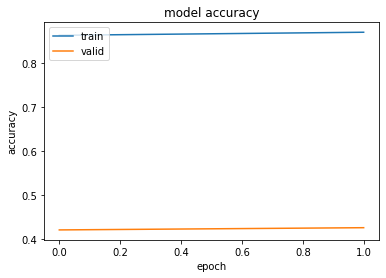

                       precision    recall  f1-score   support

            Biography       0.35      0.32      0.34       121
            Childrens       0.28      0.27      0.27       105
              Fantasy       0.44      0.60      0.51       566
           Historical       0.36      0.37      0.37       279
               Horror       0.33      0.28      0.30        80
      Mystery & Crime       0.40      0.34      0.37       269
               Poetry       0.35      0.31      0.33        55
   Politics & History       0.47      0.40      0.43       135
Religion & Philosophy       0.41      0.58      0.48       180
              Romance       0.47      0.38      0.42       418
      Science Fiction       0.40      0.24      0.30       166
       Sequential Art       0.69      0.66      0.67        92
          Young Adult       0.31      0.27      0.29       287

             accuracy                           0.41      2753
            macro avg       0.41      0.39      0.39 

In [24]:
show_results(history_nw,model)

In [71]:
predicted_classes = np.argmax(predictions, axis=1)
oclasses = list()
oclasses = [[c.numpy() for c in object[1]]for object in test_ds]
original_classes = np.concatenate(oclasses).ravel()

In [23]:
modelCNN = Sequential()
modelCNN.add(Embedding(vocab+1, 300, weights = [embedding_matrix], input_length=maxwords, trainable = True))#maxwords
modelCNN.add(layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))#a#<ll
modelCNN.add(layers.BatchNormalization())
modelCNN.add(layers.MaxPooling1D(pool_size=2))#poolsize
modelCNN.add(layers.Flatten())
modelCNN.add(Dense(len(dg),activation = 'softmax'))#vs relu
optimizer=Adam(learning_rate=0.0001,epsilon=0.1)#lr
modelCNN.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics = ['accuracy'])
ES= callbacks.EarlyStopping(monitor='loss', patience=3)

print(modelCNN.summary())



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 300)           6079800   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 41, 32)            28832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 41, 32)            128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 20, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 640)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 13)                8333      
Total params: 6,117,093
Trainable params: 6,117,029
Non-trainable params: 64
___________________________________________

In [24]:
optimizer=Adam(learning_rate=0.001,epsilon=0.1)
modelCNN.compile(optimizer='Adam',loss='categorical_crossentropy', metrics = ['accuracy'])

In [41]:
ES5= callbacks.EarlyStopping(monitor='loss', patience=5)

historyCNN = modelCNN.fit(x_train,y_train, epochs = 25, validation_data=(x_val, y_val), callbacks=[ES5], verbose=1, batch_size=128, class_weight=cw)

Epoch 1/25
203/203 [==============================] - 25s 117ms/step - loss: 0.2899 - accuracy: 0.8637 - val_loss: 3.8554 - val_accuracy: 0.3869
Epoch 2/25
203/203 [==============================] - 24s 121ms/step - loss: 0.2628 - accuracy: 0.8761 - val_loss: 3.9726 - val_accuracy: 0.3819
Epoch 3/25
203/203 [==============================] - 25s 124ms/step - loss: 0.2412 - accuracy: 0.8856 - val_loss: 4.0350 - val_accuracy: 0.3812
Epoch 4/25
203/203 [==============================] - 25s 125ms/step - loss: 0.2256 - accuracy: 0.8942 - val_loss: 4.0724 - val_accuracy: 0.3867
Epoch 5/25
203/203 [==============================] - 26s 128ms/step - loss: 0.2224 - accuracy: 0.8987 - val_loss: 4.2448 - val_accuracy: 0.3599
Epoch 6/25
203/203 [==============================] - 27s 131ms/step - loss: 0.2168 - accuracy: 0.9001 - val_loss: 4.2482 - val_accuracy: 0.3800
Epoch 7/25
203/203 [==============================] - 27s 133ms/step - loss: 0.2138 - accuracy: 0.9042 - val_loss: 4.3638 - val_ac

[0 0 0 0 0 0 0 1 0 0 0 0 0] [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


(38613, 41)

In [15]:
def prediction(sentence, modele=model):
    sentence = sentence.lower()
    sentence=sentence.split(' ')
    test = xtoken.texts_to_sequences(sentence)
    flat_list =  [[item for elem in test for item in elem]]
    bob = pad_sequences(flat_list, maxlen=41, padding='pre')
    a=modele.predict(bob)
    b=np.argmax(a, axis=1)
    pred2 = np.argsort(a,axis=1)[:,-2]
    pred3 = np.argsort(a,axis=1)[:,-3]
    genre=idx2lab[b[0]]
    return (genre, a, pred2 pred3)
    



In [24]:
prediction("love murder")

('Romance',
 array([[0.4749476 , 0.01452982, 0.53089595, 0.10134837, 0.8884505 ,
         0.8770132 , 0.04750389, 0.10779369, 0.16176668, 0.9239906 ,
         0.53383493, 0.44093302, 0.8590435 ]], dtype=float32))

In [209]:
# ne pas exécuter
sentence='I love you'
sentence = sentence.lower()
sentence=sentence.split(' ')
test = xtoken.texts_to_sequences(sentence)
flat_list =  [[item for elem in test for item in elem]]
bob = pad_sequences(flat_list, maxlen=41, padding='pre')
print (sentence, test, flat_list, bob)

['i', 'love', 'you'] [[16], [11], [15]] [[16, 11, 15]] [[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0 16 11 15]]


In [176]:
from sklearn.metrics import classification_report
print(classification_report( y_train, predicted_classes, target_names=class_names))

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,   319,     1,   168, 10218,     8,    35,     4,
         197,     5,     3,  6958, 10219])

In [44]:
model.save('C:/Users/benoi/Documents/HEC/_Hiver 2021/Machine Learning/projet/CNN-LSTM')

INFO:tensorflow:Assets written to: C:/Users/benoi/Documents/HEC/_Hiver 2021/Machine Learning/projet/CNN-LSTM\assets


INFO:tensorflow:Assets written to: C:/Users/benoi/Documents/HEC/_Hiver 2021/Machine Learning/projet/CNN-LSTM\assets
